In [1]:
!pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [33]:
import argparse
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19

In [34]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps

In [35]:
class Fusion:
    def __init__(self, input):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuse self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for img in self.input_images]
        self.YCbCr_images = [-1 for img in self.input_images]
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._tranfer_to_tensor()
        # Perform fuse strategy
        fused_img = self._fuse()[:, :, 0]
        # Reconstruct fused image given rgb input images
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)
        # return fused_img

    def _fuse(self):
        """
        Perform fusion algorithm
        """
        with torch.no_grad():

            imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:,idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output
        
        
    def _RGB_to_YCbCr(self, img_RGB):
            """
            A private method which converts an RGB image to YCrCb format
            """
            img_RGB = img_RGB.astype(np.float32) / 255.
            return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):
            """
            A private method which converts a YCrCb image to RGB format
            """
            img_YCbCr = img_YCbCr.astype(np.float32)
            return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):
            """
            A private method which returns True if image is gray, otherwise False
            """
            if len(img.shape) < 3:
                return True
            if img.shape[2] == 1:
                return True
            b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
            if (b == g).all() and (b == r).all():
                return True
            return False

    def _softmax(self, tensor):
            """
            A private method which compute softmax ouput of a given tensor
            """
            tensor = torch.exp(tensor)
            tensor = tensor / tensor.sum(dim=1, keepdim=True)
            return tensor

    def _tranfer_to_tensor(self):
            """
            A private method to transfer all input images to PyTorch tensors
            """
            self.images_to_tensors = []
            for image in self.normalized_images:
                np_input = image.astype(np.float32)
                if np_input.ndim == 2:
                    np_input = np.repeat(np_input[None, None], 3, axis=1)
                else:
                    np_input = np.transpose(np_input, (2, 0, 1))[None]
                if self.device == "cuda":
                    self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
                else:
                    self.images_to_tensors.append(torch.from_numpy(np_input)) 

In [9]:
!pip install PyWavelets

In [36]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

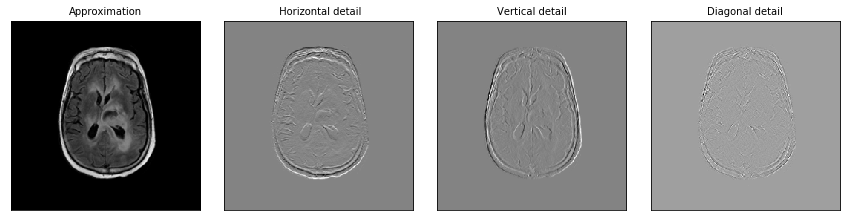

In [45]:
# Load MRI image
mri_image = cv2.imread('jpg/mri_registered.jpg')
mri_image = cv2.cvtColor(mri_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(mri_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='jpg/mri_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

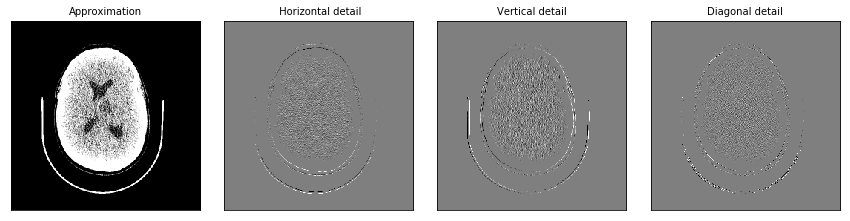

In [46]:
# Load CT Image
ct_image = cv2.imread('jpg/ct.jpg')
ct_image = cv2.cvtColor(ct_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(ct_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='jpg/ct_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

#### Run VGG19 on the 4 bands of Images

In [47]:
# Calling the methods for Siamese on LL Images
input_images = []
mri = cv2.imread('jpg/mri_0.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_0.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_0.jpg', fusion_img)

True

In [48]:
# Calling the methods for Siamese on LH Images
input_images = []
mri = cv2.imread('jpg/mri_1.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_1.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_1.jpg', fusion_img)

True

In [49]:
# Calling the methods for Siamese on LV Images
input_images = []
mri = cv2.imread('jpg/mri_2.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_2.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_2.jpg', fusion_img)

True

In [50]:
# Calling the methods for Siamese on LD Images
input_images = []
mri = cv2.imread('jpg/mri_3.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('jpg/ct_3.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('jpg/fusion_3.jpg', fusion_img)

True

#### Reconstruction Using Inverse Wavelet Transform

In [51]:
fusion_0 = cv2.imread('jpg/fusion_0.jpg')
fusion_0 = cv2.cvtColor(fusion_0, cv2.COLOR_BGR2GRAY)

fusion_1 = cv2.imread('jpg/fusion_1.jpg')
fusion_1 = cv2.cvtColor(fusion_1, cv2.COLOR_BGR2GRAY)

fusion_2 = cv2.imread('jpg/fusion_2.jpg')
fusion_2 = cv2.cvtColor(fusion_2, cv2.COLOR_BGR2GRAY)

fusion_3 = cv2.imread('jpg/fusion_3.jpg')
fusion_3 = cv2.cvtColor(fusion_3, cv2.COLOR_BGR2GRAY)

coeffs=(fusion_0,(fusion_1,fusion_2,fusion_3))

In [52]:
fusion=pywt.idwt2(coeffs,'haar')
cv2.imwrite('jpg/final_fusion.jpg',fusion)

True